Sistem Rekomendasi Olahraga (Hybrid CF + CBF)
------------------------------------------------------
Dokumentasi ini menjelaskan alur:
1. Import library
2. Muat dataset
3. Pra-proses data (gabung, hitung kalori, encoding)
4. Membangun dan melatih model hybrid (Deep Learning)
5. Membangun matriks Content-Based (TF-IDF + Cosine)
6. Menghasilkan rekomendasi hybrid
"""

# Import Library

In [41]:
!pip install tensorflowjs

In [42]:
import pandas as pd
import numpy as np

# TensorFlow / Keras untuk model hybrid (Collaborative Filtering + Content)
import tensorflow as tf
from tensorflow import keras
import tensorflowjs as tfjs
from tensorflow.keras import layers

# Scikit-Learn untuk encoding dan TF-IDF / cosine similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Matplotlib untuk visualisasi metrik training
import matplotlib.pyplot as plt

# Colab untuk menyimpan file
from google.colab import files

# Data Loading

In [43]:
def load_datasets():
    """
    Memuat ketiga dataset dari GitHub:
      - olahraga.csv
      - history_olahraga.csv
      - user_dataset.csv
    dan mengembalikannya sebagai tiga DataFrame.
    """
    url_base = (
        "https://raw.githubusercontent.com/"
        "hilmanfaujiabdilah/capstone-rekomendasi-olahraga/"
        "refs/heads/main/dataset%20olahraga"
    )
    df_olahraga = pd.read_csv(f"{url_base}/olahraga.csv")
    df_history  = pd.read_csv(f"{url_base}/history_olahraga.csv")
    df_user     = pd.read_csv(f"{url_base}/user_dataset.csv")
    return df_olahraga, df_history, df_user

In [44]:
df_olahraga, df_history_orig, df_user = load_datasets()

# Explpratory Data Analysis

In [45]:
def exploratory_data(df_olahraga, df_history, df_user):
    """
    Sekilas informasi tentang ketiga DataFrame.
    """
    print("=== df_olahraga ===")
    print(df_olahraga.info(), end="\n\n")
    print("=== df_history ===")
    print(df_history.info(), end="\n\n")
    print("=== df_user ===")
    print(df_user.info(), end="\n\n")

    # Cek jumlah jenis latihan unik
    unique_latihan = df_olahraga['latihan'].unique()
    print(f"Banyak jenis olahraga: {len(unique_latihan)}")
    print("Contoh jenis olahraga:", unique_latihan[:5], "…")

In [46]:
exploratory_data(df_olahraga,df_history_orig, df_user)

=== df_olahraga ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_olahraga  156 non-null    int64  
 1   latihan      156 non-null    object 
 2   kalori_jam   156 non-null    int64  
 3   km           156 non-null    float64
 4   Tingkat      156 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 6.2+ KB
None

=== df_history ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5545 entries, 0 to 5544
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_history        5545 non-null   int64 
 1   id_user           5545 non-null   int64 
 2   id_olahraga       5545 non-null   int64 
 3   tanggal_olahraga  5545 non-null   object
 4   durasi_menit      5545 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 216.7+ KB
None

=== df_us

# Dat Preprocessing

In [47]:
def merge_data(df_history: pd.DataFrame,
               df_user: pd.DataFrame,
               df_olahraga: pd.DataFrame) -> pd.DataFrame:
    """
    1) Merge df_history dengan df_user (ambil aktivitas_harian, rutin_olahraga)
    2) Merge hasilnya dengan df_olahraga (ambil kalori_jam)
    """
    # merge dengan df_user
    df = (
        df_history
        .merge(
            df_user[['id_user', 'aktivitas_harian', 'rutin_olahraga']],
            on='id_user',
            how='left'
        )
        .merge(
            df_olahraga[['id_olahraga', 'kalori_jam']],
            on='id_olahraga',
            how='left'
        )
    )
    return df.copy()  # .copy() untuk menghindari SettingWithCopyWarning

In [48]:
def compute_calories(df: pd.DataFrame) -> pd.DataFrame:
    """
    Tambahkan kolom 'kalori_terbakar' = (durasi_menit / 60) * kalori_jam
    """
    df = df.assign(
        kalori_terbakar=lambda d: (d['durasi_menit'] / 60) * d['kalori_jam']
    )
    return df

In [49]:
def encode_ids(df: pd.DataFrame) -> tuple[pd.DataFrame, dict, dict, dict, dict]:
    """
    1) Label encoding untuk id_user → user_to_encoded, encoded_to_user
    2) Label encoding untuk id_olahraga → olahraga_to_encoded, encoded_to_olahraga

    Mengembalikan:
      - df dengan dua kolom baru: 'user_encoded' & 'olahraga_encoded'
      - 4 buah dictionary mapping (user_to_encoded, encoded_to_user, olahraga_to_encoded, encoded_to_olahraga)
    """
    # Label encode id_user
    user_ids = df['id_user'].unique().tolist()
    user_to_encoded = {uid: idx for idx, uid in enumerate(user_ids)}
    encoded_to_user = {idx: uid for idx, uid in enumerate(user_ids)}
    df = df.assign(user_encoded=lambda d: d['id_user'].map(user_to_encoded))

    # Label encode id_olahraga
    olahraga_ids = df['id_olahraga'].unique().tolist()
    olahraga_to_encoded = {oid: idx for idx, oid in enumerate(olahraga_ids)}
    encoded_to_olahraga = {idx: oid for idx, oid in enumerate(olahraga_ids)}
    df = df.assign(olahraga_encoded=lambda d: d['id_olahraga'].map(olahraga_to_encoded))

    return df, user_to_encoded, encoded_to_user, olahraga_to_encoded, encoded_to_olahraga

In [50]:
def encode_latihan(df: pd.DataFrame,
                   df_olahraga: pd.DataFrame) -> tuple[pd.DataFrame, dict, dict]:
    """
    1) Ambil mapping id_olahraga → nama latihan dari df_olahraga
    2) Buat label encoding untuk nama latihan (latihan_to_encoded, encoded_to_latihan)
    3) Tambahkan kolom 'latihan_encoded' ke df

    Kembalikan:
      - df dengan kolom 'latihan_encoded'
      - dua dictionary mapping (latihan_to_encoded, encoded_to_latihan)
    """
    # 1) mapping id_olahraga → nama latihan
    mapping_latihan = df_olahraga.set_index('id_olahraga')['latihan'].to_dict()
    # 2) daftar nama latihan unik
    latihan_names = df_olahraga['latihan'].unique().tolist()
    latihan_to_encoded = {name: idx for idx, name in enumerate(latihan_names)}
    encoded_to_latihan = {idx: name for idx, name in enumerate(latihan_names)}
    # 3) tambahkan kolom 'latihan_encoded'
    df = df.assign(
        latihan_encoded=lambda d: d['id_olahraga']
                                  .map(mapping_latihan)
                                  .map(latihan_to_encoded)
    )
    return df, latihan_to_encoded, encoded_to_latihan

In [51]:
def one_hot_encode_features(df: pd.DataFrame,
                            fitur_kategori: list[str]
                           ) -> tuple[pd.DataFrame, OneHotEncoder, list[str]]:
    """
    One-Hot encode kolom di 'fitur_kategori' (contoh: ['aktivitas_harian','rutin_olahraga'])
    Mengembalikan:
      - df (tanpa kolom asli fitur_kategori, tapi sudah ditambahkan kolom hasil OHE)
      - objek OneHotEncoder (untuk digunakan di proses inference jika perlu)
      - list nama kolom baru hasil OHE
    """
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    arr_ohe = ohe.fit_transform(df[fitur_kategori])
    nama_kol_ohe = ohe.get_feature_names_out(fitur_kategori)
    df_ohe = pd.DataFrame(arr_ohe, columns=nama_kol_ohe, index=df.index)
    # Buang kolom asli fitur_kategori, lalu gabungkan df_ohe
    df = pd.concat([df.drop(columns=fitur_kategori), df_ohe], axis=1)
    return df, ohe, list(nama_kol_ohe)

In [52]:
def normalize_features(df: pd.DataFrame,
                       kolom_durasi: str = 'durasi_menit',
                       kolom_kalori: str = 'kalori_terbakar'
                      ) -> tuple[pd.DataFrame, float, float, float, float]:
    """
    1) Hitung min/max untuk durasi (kolom_durasi) dan kalori (kolom_kalori)
    2) Tambahkan kolom 'durasi_normal' dan 'kalori_terbakar_normal'
    Mengembalikan juga 4 nilai: durasi_min, durasi_max, kalori_min, kalori_max
    (bisa disimpan untuk keperluan reverse‐normalization atau inference).
    """
    durasi_min = df[kolom_durasi].min()
    durasi_max = df[kolom_durasi].max()
    kalori_min = df[kolom_kalori].min()
    kalori_max = df[kolom_kalori].max()

    df = df.assign(
        durasi_normal=lambda d: (d[kolom_durasi] - durasi_min) / (durasi_max - durasi_min),
        kalori_terbakar_normal=lambda d: (d[kolom_kalori] - kalori_min) / (kalori_max - kalori_min)
    )
    return df, durasi_min, durasi_max, kalori_min, kalori_max

In [53]:
def build_X_y(df: pd.DataFrame,
              nama_kol_input: list[str],
              nama_kol_target: str = 'kalori_terbakar_normal'
             ) -> tuple[np.ndarray, np.ndarray]:
    """
    1) Kumpulkan kolom input (X_all) berdasarkan 'nama_kol_input'
    2) Ambil kolom target (y_all)
    Kembalikan X_all (numpy array float32) dan y_all (numpy array float32)
    """
    X_all = df[nama_kol_input].values.astype(np.float32)
    y_all = df[nama_kol_target].values.astype(np.float32)
    return X_all, y_all

In [54]:
def split_train_val(X_all: np.ndarray,
                    y_all: np.ndarray,
                    frac_train: float = 0.8
                   ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Bagi X_all & y_all menjadi train/validation.
    - frac_train: proporsi data yang masuk ke train. Sisanya untuk val.
    """
    num_samples = X_all.shape[0]
    idx_split = int(frac_train * num_samples)
    X_train, X_val = X_all[:idx_split], X_all[idx_split:]
    y_train, y_val = y_all[:idx_split], y_all[idx_split:]
    return X_train, X_val, y_train, y_val

In [55]:
# Merge data
df_merged = merge_data(df_history_orig, df_user, df_olahraga)

In [56]:
# Hitung kalori terbakar
df_calculated = compute_calories(df_merged)

In [57]:
# Encode id_user & id_olahraga
(   df_ids_encoded,
    user_to_enc, encoded_to_user,
    olahraga_to_enc, encoded_to_olahraga ) = encode_ids(df_calculated)

In [58]:
# Encode nama latihan (konten item)
(   df_with_latihan,
    latihan_to_enc, encoded_to_latihan
) = encode_latihan(df_ids_encoded, df_olahraga)

In [59]:
# One-Hot Encode kolom kategori
fitur_kategori = ['aktivitas_harian', 'rutin_olahraga']
(   df_ohe,
    ohe_encoder,
    ohe_colnames
) = one_hot_encode_features(df_with_latihan, fitur_kategori)

In [60]:
# Normalisasi durasi_menit & kalori_terbakar
(   df_normalized,
    durasi_min, durasi_max,
    kalori_min, kalori_max
) = normalize_features(df_ohe,
                       kolom_durasi='durasi_menit',
                       kolom_kalori='kalori_terbakar')

In [61]:
# Siapkan nama kolom input untuk X_all
# Urutan: ['user_encoded', 'olahraga_encoded', 'latihan_encoded', 'durasi_normal'] + ohe_colnames
nama_kol_input = ['user_encoded', 'olahraga_encoded', 'latihan_encoded',
                  'durasi_normal'] + ohe_colnames

In [62]:
# Bangun X_all dan y_all
X_all, y_all = build_X_y(df_normalized, nama_kol_input, nama_kol_target='kalori_terbakar_normal')

In [63]:
# Split data menjadi train (80%) dan validation (20%)
X_train, X_val, y_train, y_val = split_train_val(X_all, y_all, frac_train=0.8)

In [64]:
# Hitung variabel‐variabel penting untuk model
num_users = len(user_to_enc)
num_olahraga = len(olahraga_to_enc)
num_latihan = len(latihan_to_enc)
num_add_feats = X_train.shape[1] - 3  # fitur tambahan (durasi_normal + one-hot)

In [65]:
# Kumpulkan metadata encoding dalam satu dict
metadata = {
    'user_to_encoded': user_to_enc,
    'encoded_to_user': encoded_to_user,
    'olahraga_to_encoded': olahraga_to_enc,
    'encoded_to_olahraga': encoded_to_olahraga,
    'latihan_to_encoded': latihan_to_enc,
    'encoded_to_latihan': encoded_to_latihan,
    'ohe_encoder': ohe_encoder,
    'ohe_colnames': ohe_colnames,
    'durasi_min': durasi_min,
    'durasi_max': durasi_max,
    'kalori_min': kalori_min,
    'kalori_max': kalori_max
}

# Deklarasi Model Hybrid (CF + CBF)

In [66]:
class HybridRecommenderNet(keras.Model):
    """
    Model Hybrid untuk sistem rekomendasi:
    - Embedding user (CF)
    - Embedding olahraga (CF)
    - Embedding jenis latihan (fitur konten/item)
    - Dense layers untuk memprediksi skor (kalori_terbakar_normal)
    """

    def __init__(self, num_users, num_olahraga, num_latihan, embedding_size, num_additional_features, **kwargs):
        super(HybridRecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1)

        self.olahraga_embedding = layers.Embedding(
            input_dim=num_olahraga,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.olahraga_bias = layers.Embedding(input_dim=num_olahraga, output_dim=1)

        self.latihan_embedding = layers.Embedding(
            input_dim=num_latihan,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Dense layer untuk memproses gabungan embedding + additional features
        dense_input_size = embedding_size * 3 + num_additional_features
        self.dense_1 = layers.Dense(
            units=64, activation='relu',
            kernel_regularizer=keras.regularizers.l2(1e-6)
        )
        self.output_layer = layers.Dense(1)  # Prediksi skor (kalori_terbakar_normal)

    def call(self, inputs):
        """
        inputs: tensor shape = (batch_size, 3 + num_additional_features)
          Kolom ke-0: user_encoded (int)
          Kolom ke-1: olahraga_encoded (int)
          Kolom ke-2: latihan_encoded (int)
          Kolom ke-3 dst: fitur tambahan (durasi_normal + One-Hot)
        """
        user_idx       = tf.cast(inputs[:, 0], tf.int32)
        olahraga_idx   = tf.cast(inputs[:, 1], tf.int32)
        latihan_idx    = tf.cast(inputs[:, 2], tf.int32)
        additional_feats = inputs[:, 3:]

        # Ambil embedding dan bias
        user_vec     = self.user_embedding(user_idx)
        user_bias    = self.user_bias(user_idx)       # (batch_size, 1)

        olahraga_vec = self.olahraga_embedding(olahraga_idx)
        olahraga_bias= self.olahraga_bias(olahraga_idx)  # (batch_size, 1)

        latihan_vec  = self.latihan_embedding(latihan_idx)

        # Gabungkan semua embedding + fitur tambahan
        x = tf.concat([user_vec, olahraga_vec, latihan_vec, additional_feats], axis=1)

        # Proses melalui Dense layer
        x = self.dense_1(x)  # (batch_size, 64)

        # Tambahkan bias (user_bias + olahraga_bias)
        # Pastikan dimensi (batch_size, 1) → (batch_size, 1) agar bisa dijumlahkan
        x = x + tf.squeeze(user_bias, axis=-1)[:, tf.newaxis]
        x = x + tf.squeeze(olahraga_bias, axis=-1)[:, tf.newaxis]

        # Output (prediksi skor)
        output = self.output_layer(x)
        return tf.nn.sigmoid(output)  # sigmoid karena target sudah dinormalisasi [0,1]

# training Model Hybrid

In [67]:
embedding_size = 50
model_hybrid = HybridRecommenderNet(
    num_users=num_users,
    num_olahraga=num_olahraga,
    num_latihan=num_latihan,
    embedding_size=embedding_size,
    num_additional_features=num_add_feats
)

In [68]:
# Kompilasi model dengan MeanSquaredError (karena target kontinu yang sudah dinormalisasi)
model_hybrid.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
)

In [69]:
print("\n=== Memulai pelatihan model hybrid ===")
history_hybrid = model_hybrid.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=20,  # Bisa disesuaikan
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


=== Memulai pelatihan model hybrid ===
Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0352 - mse: 0.0349 - val_loss: 0.0025 - val_mse: 0.0022
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0015 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 7.2686e-04
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 9.5711e-04 - mse: 6.2841e-04 - val_loss: 9.6826e-04 - val_mse: 6.4378e-04
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 7.8050e-04 - mse: 4.5748e-04 - val_loss: 9.1158e-04 - val_mse: 5.9370e-04
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.0166e-04 - mse: 3.8568e-04 - val_loss: 8.4047e-04 - val_mse: 5.2979e-04
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.3653e-04 - mse: 3.2860e-04 - val_loss: 7.8282e-04 - val_mse: 4.8161e-04
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.8334e-04 - mse: 2.8613e-04 - val_loss: 6.9139e-04 - val_mse: 4.0463e-04
Epoch 8/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms

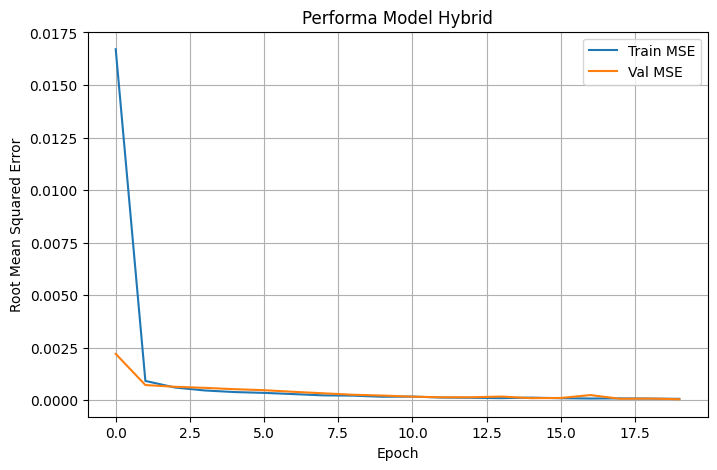

In [70]:
# Visualisasi kurva RMSE (Train vs Validation)
plt.figure(figsize=(8, 5))
plt.plot(history_hybrid.history['mse'], label='Train MSE')
plt.plot(history_hybrid.history['val_mse'], label='Val MSE')
plt.title('Performa Model Hybrid')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Membangun Content Based Matrix

In [71]:
def build_content_matrix(df_olahraga: pd.DataFrame) -> pd.DataFrame:
    """
    Membangun matriks cosine similarity antar item (id_olahraga) dengan
    fitur gabungan: 'latihan' + 'kalori_jam' → di‐TFIDF kan.
    """
    data = df_olahraga[['id_olahraga', 'latihan', 'kalori_jam']].copy()
    data['combined'] = data['latihan'] + " " + data['kalori_jam'].astype(str)

    tfidf = TfidfVectorizer()
    tfidf_mat = tfidf.fit_transform(data['combined'])  # shape = (num_items, num_features)

    cos_sim_matrix = cosine_similarity(tfidf_mat)      # shape = (num_items, num_items)

    # Buat DataFrame cosine similarity, index & columns = id_olahraga
    cb_df = pd.DataFrame(
        data=cos_sim_matrix,
        index=data['id_olahraga'],
        columns=data['id_olahraga']
    )
    return cb_df

In [72]:
cb_similarity_df = build_content_matrix(df_olahraga)

# Rekomendasi Hybrid

In [73]:
def recommend_hybrid_for_user(
    user_id: int,
    df_olahraga: pd.DataFrame,
    df_history_original: pd.DataFrame,
    model_hybrid: keras.Model,
    cb_matrix: pd.DataFrame,
    metadata: dict,
    top_k: int = 10,
    alpha: float = 0.6
) -> pd.DataFrame:
    """
    Menghasilkan rekomendasi hybrid (CF + CBF) untuk satu user.
    """
    # 1) Pastikan user ada di metadata
    user_to_encoded = metadata['user_to_encoded']
    olahraga_to_encoded = metadata['olahraga_to_encoded']
    if user_id not in user_to_encoded:
        raise ValueError(f"User {user_id} tidak ditemukan dalam metadata.")

    # 2) Dapatkan indeks user
    u_enc = user_to_encoded[user_id]

    # 3) Cari daftar item yang sudah pernah dicoba user
    visited_items = df_history_original.loc[
        df_history_original['id_user'] == user_id, 'id_olahraga'
    ].unique()

    # 4) Buat daftar semua kandidat yang belum pernah dicoba
    all_ol_ids = df_olahraga['id_olahraga'].unique().tolist()
    candidates = [oid for oid in all_ol_ids if oid not in visited_items]
    n_cand = len(candidates)

    # 5) Hitung skor CF (model_hybrid.predict) untuk masing‐masing kandidat
    #    - Untuk setiap kandidat, kita butuh vector input sebanyak (2 + num_add_feats)
    num_add_feats = X_train.shape[1] - 2  # asumsi X_train ada di global scope
    X_cand = np.zeros((n_cand, 2 + num_add_feats), dtype=np.float32)
    for i, oid in enumerate(candidates):
        X_cand[i, 0] = u_enc
        X_cand[i, 1] = olahraga_to_encoded[oid]
        # Sisanya (fitur durasi_normal + one-hot) dibiarkan 0

    cf_preds = model_hybrid.predict(X_cand, verbose=0).flatten()

    # 6) Normalisasi skor CF ke rentang [0,1]
    def normalize(arr: np.ndarray) -> np.ndarray:
        if arr.max() == arr.min():
            return np.zeros_like(arr)
        return (arr - arr.min()) / (arr.max() - arr.min())

    cf_norm = normalize(cf_preds)

    # 7) Hitung skor CBF (rata-rata cosine similarity kandidat dengan visited_items)
    if len(visited_items) == 0:
        cb_scores = np.zeros(n_cand)
    else:
        cb_scores = np.array([
            cb_matrix.loc[oid, visited_items].mean()
            for oid in candidates
        ])

    cb_norm = normalize(cb_scores)

    # 8) Gabungkan menjadi skor hybrid dengan bobot alpha
    hybrid_scores = alpha * cf_norm + (1 - alpha) * cb_norm

    # 9) Pilih top_k tertinggi
    top_idx = np.argsort(hybrid_scores)[-top_k:][::-1]
    top_oids = [candidates[i] for i in top_idx]

    # 10) Kumpulkan hasil (nama latihan, rata-rata durasi, rata-rata kalori, skor hybrid)
    avg_durasi = df_history_original.groupby('id_olahraga')['durasi_menit'].mean().to_dict()
    kalori_jam = df_olahraga.set_index('id_olahraga')['kalori_jam'].to_dict()

    results = []
    for i, oid in enumerate(top_oids):
        nama_latihan = df_olahraga.loc[df_olahraga['id_olahraga'] == oid, 'latihan'].iloc[0]
        durasi_rata = avg_durasi.get(oid, 0.0)
        kalori_rata = (durasi_rata / 60) * kalori_jam.get(oid, 0.0)
        skor_hyb = hybrid_scores[top_idx[i]]
        results.append({
            'id_olahraga': oid,
            'latihan': nama_latihan,
            'rata_durasi_menit': round(durasi_rata, 1),
            'rata_kalori_terbakar': round(kalori_rata, 1),
            'skor_hybrid': round(float(skor_hyb), 4)
        })

    df_results = pd.DataFrame(results)
    return df_results

# Penggunaan Funsionalitas Rekomendasi

In [74]:
if __name__ == "__main__":
    # Ambil satu user secara acak dari df_history_orig (untuk contoh)
    user_sample = df_history_orig['id_user'].sample(1).iloc[0]
    print(f"\n>>> Rekomendasi hybrid untuk user {user_sample} <<<\n")

    df_rekom = recommend_hybrid_for_user(
        user_id=user_sample,
        df_olahraga=df_olahraga,
        df_history_original=df_history_orig,
        model_hybrid=model_hybrid,
        cb_matrix=cb_similarity_df,
        metadata=metadata,
        top_k=10,
        alpha=0.6
    )
    print(df_rekom.to_string(index=False))


>>> Rekomendasi hybrid untuk user 603 <<<

 id_olahraga          latihan  rata_durasi_menit  rata_kalori_terbakar  skor_hybrid
          82          Aerobik               67.0                 573.7       0.6414
         109        Bersepeda               68.4                 585.5       0.6186
         156 Lari - 16 km/jam               62.1                1216.2       0.6000
          89       Kickboxing               64.5                 552.2       0.5937
          84             HIIT               67.6                 579.0       0.5903
         103         Crossfit               60.4                 517.1       0.5881
          97        Taekwondo               64.7                 554.2       0.5878
         154 Lari - 13 km/jam               73.2                1211.1       0.5804
          98              TRX               60.2                 516.1       0.5762
         104           Curves               74.8                 641.1       0.5747


# Saved Model to TFJS

In [75]:
tfjs_model_dir = '/content/hybrid_recommender_tfjs'

tfjs.converters.save_keras_model(model_hybrid, tfjs_model_dir)

print(f"\nModel Keras berhasil disimpan ke format TFJS di: {tfjs_model_dir}")

!zip -r /content/hybrid_recommender_tfjs.zip {tfjs_model_dir}
files.download('/content/hybrid_recommender_tfjs.zip')

failed to lookup keras version from the file,
    this is likely a weight only file

Model Keras berhasil disimpan ke format TFJS di: /content/hybrid_recommender_tfjs
  adding: content/hybrid_recommender_tfjs/ (stored 0%)
  adding: content/hybrid_recommender_tfjs/group1-shard1of1.bin (deflated 8%)
  adding: content/hybrid_recommender_tfjs/model.json (deflated 68%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>